In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.compat.v1.nn import fused_batch_norm
from tensorflow.keras.activations import relu, sigmoid
import time

In [2]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [3]:
# Create a Classifier class

class Classifier:
    def __init__(self):
        self.model = None
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [4]:
# Define Meso4 class

class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        super(Meso4, self).__init__()
        self.model = self.init_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

# Instantiate a MesoNet model with pretrained weights
meso = Meso4()

# Load weights from a file
weights_file = 'weight/Meso4_DF.h5'
meso.model.load_weights(weights_file)

In [5]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7106 images belonging to 2 classes.


In [6]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

In [7]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 7106 images belonging to 2 classes.


{'DeepFake': 0, 'Real': 1}

1/1 [==============================] - 0s 411ms/step
Predicted likelihood: 0.9395
Actual label: 1
1/1 [==============================] - 0s 52ms/step

Correct prediction: True


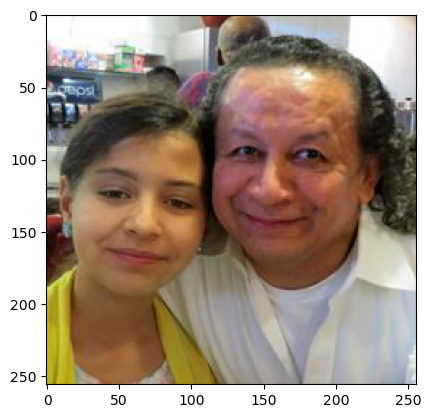

In [8]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [9]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [10]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 35ms/step
0  predictions completed.
1/1 [==============================] - 0s 31ms/step
1000  predictions completed.
1/1 [==============================] - 0s 34ms/step
2000  predictions completed.
1/1 [==============================] - 0s 32ms/step
3000  predictions completed.
1/1 [==============================] - 0s 31ms/step
4000  predictions completed.
1/1 [==============================] - 0s 27ms/step
5000  predictions completed.
1/1 [==============================] - 0s 31ms/step
6000  predictions completed.
1/1 [==============================] - 0s 33ms/step
7000  predictions completed.
1/1 [==============================] - 0s 38ms/step
All 7106 predictions completed


1/1 [==============================] - 0s 36ms/step
2000  predictions completed.
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step
3000  predictions completed.
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 31ms/step
4000  predictions completed.
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step
5000  predictions completed.
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 48ms/step
6000  predictions completed.
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step
7000  predictions completed.
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step
All 7106 predictions completed


In [11]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

# Adjust tight layout with specific parameters
plt.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0)
plt.show()

<Figure size 640x480 with 0 Axes>

C:\Users\dell\AppData\Local\Temp\ipykernel_9796\3555569109.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


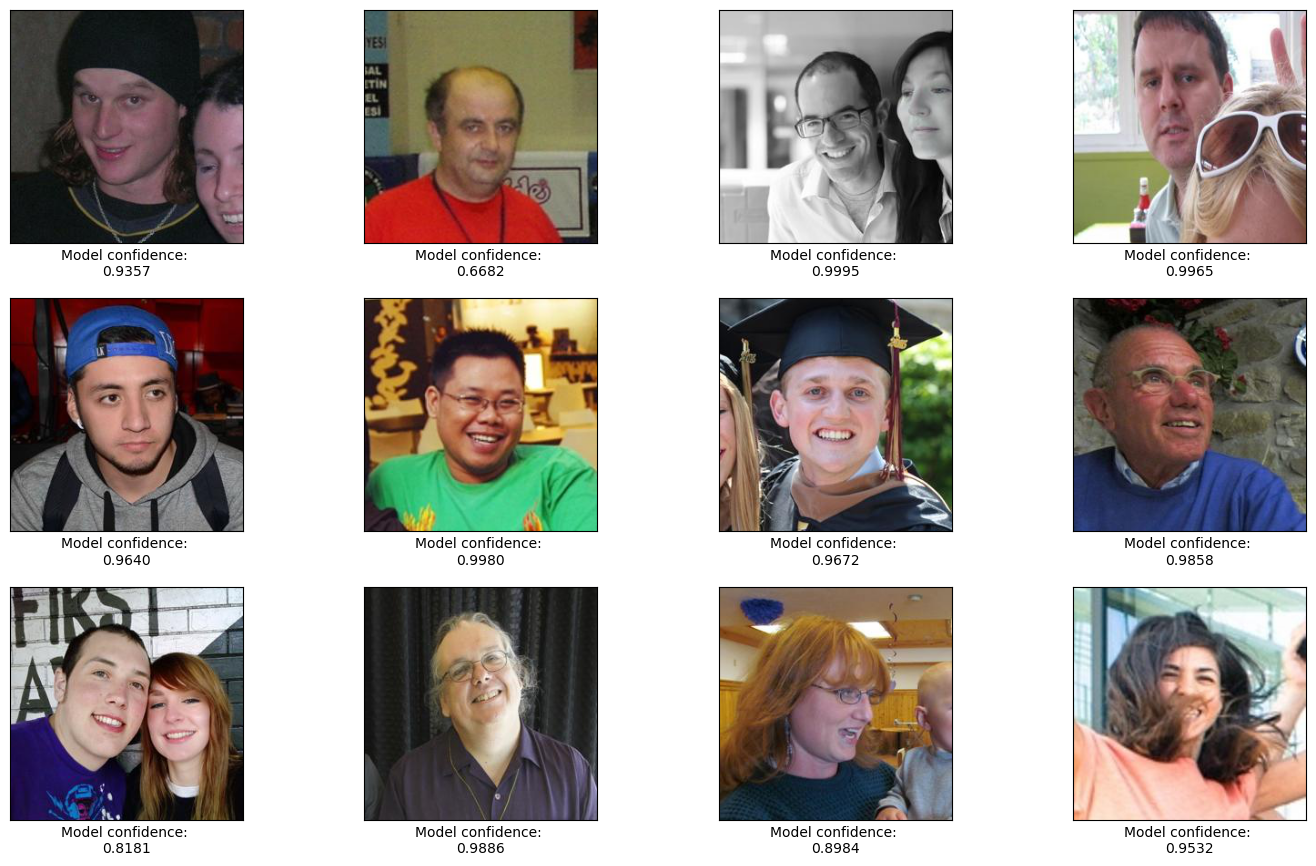

In [12]:
plotter(correct_real, correct_real_pred)

C:\Users\dell\AppData\Local\Temp\ipykernel_9796\3555569109.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


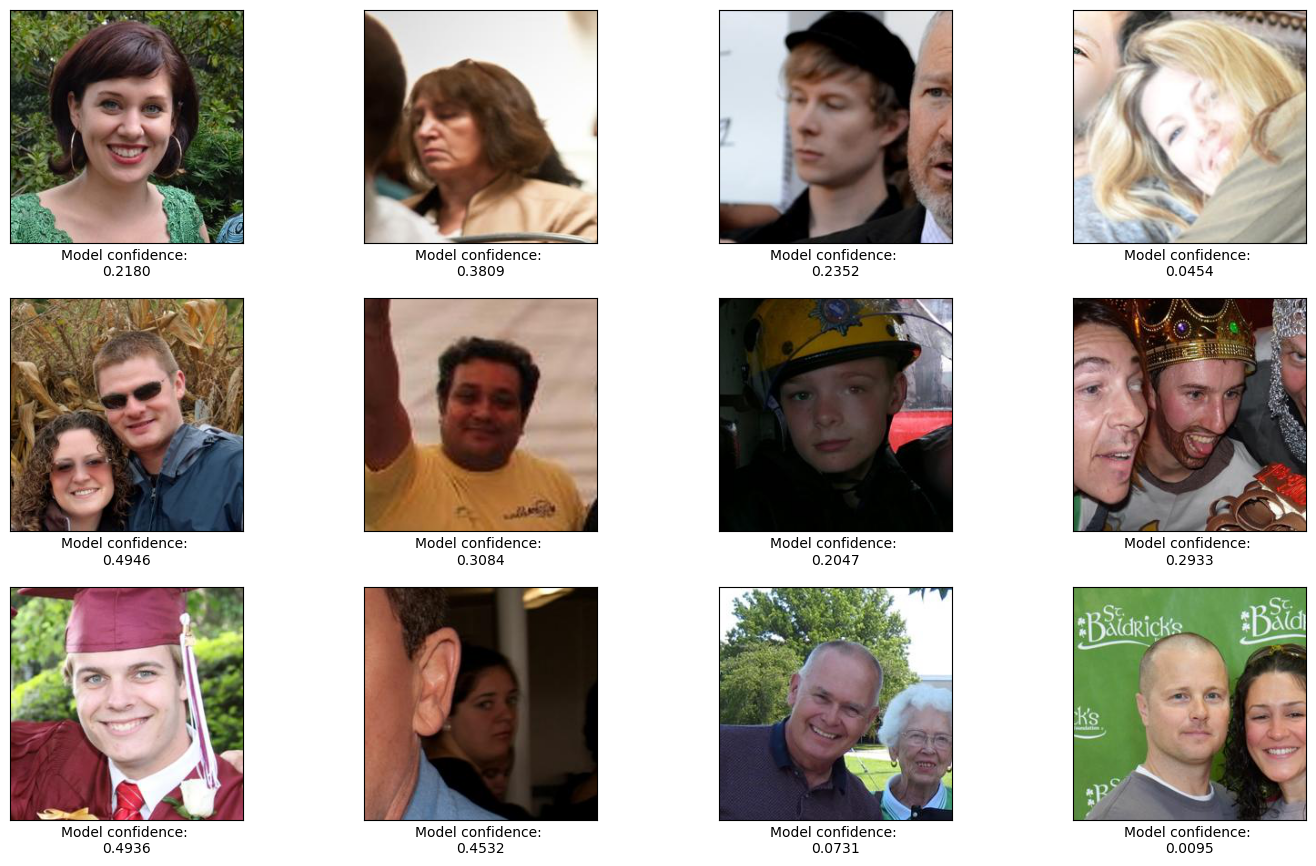

In [13]:
plotter(misclassified_real, misclassified_real_pred)

C:\Users\dell\AppData\Local\Temp\ipykernel_9796\3555569109.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


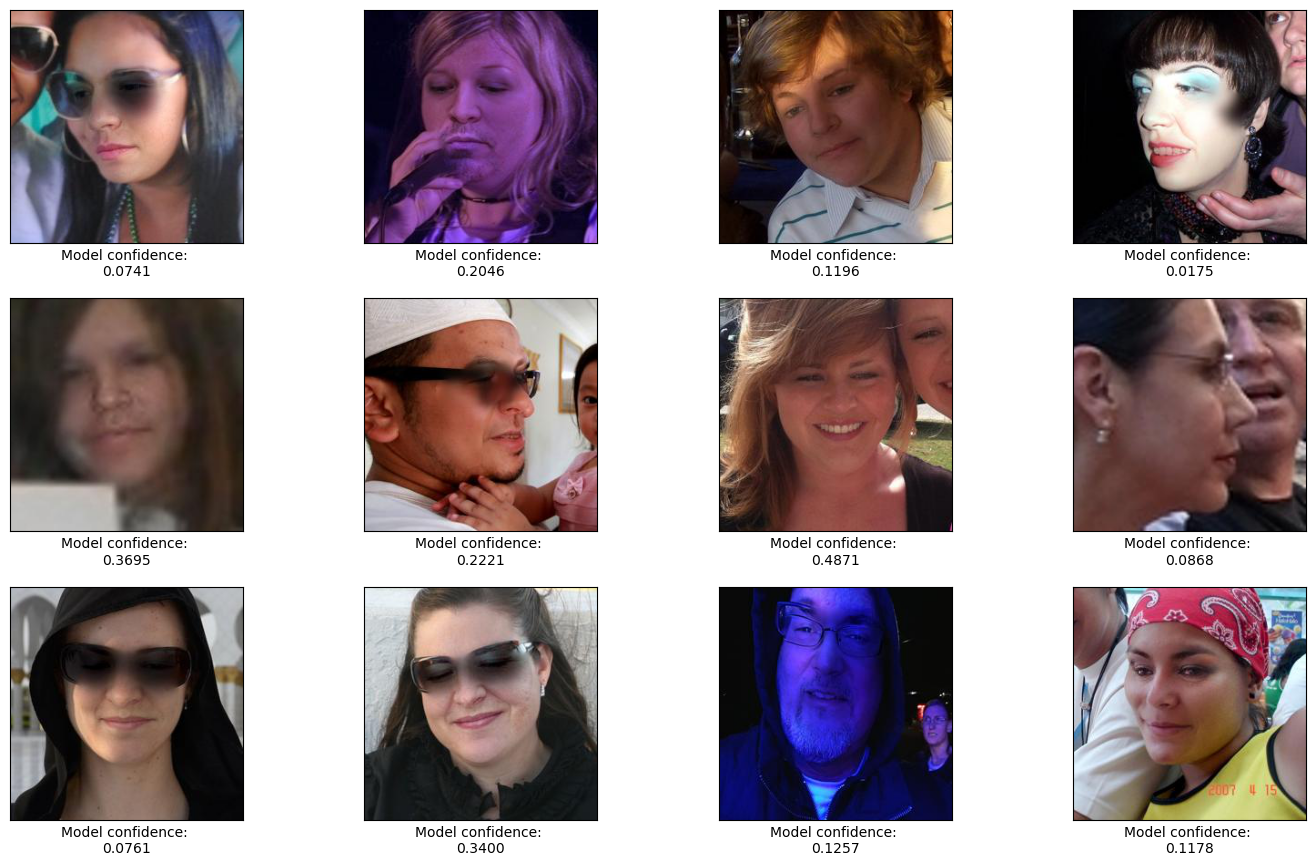

In [14]:
plotter(correct_deepfake, correct_deepfake_pred)

C:\Users\dell\AppData\Local\Temp\ipykernel_13628\3555569109.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


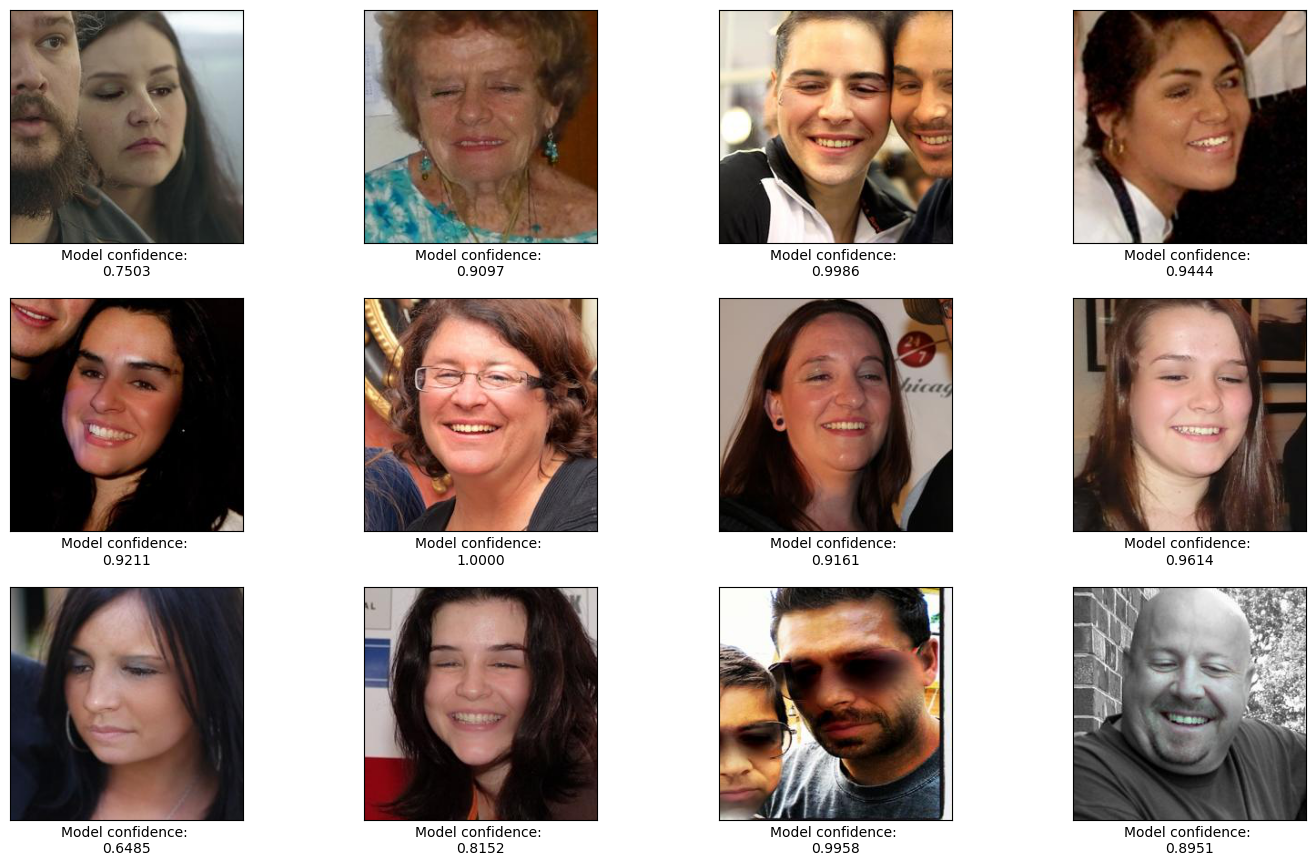

In [15]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)